<a href="https://colab.research.google.com/github/shaheerzubery/Whisper/blob/main/adapting_pretrained_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adapting pyannote.audio 2.1 pretrained speaker diarization pipeline to your own data

> "How I reached 1st place at Ego4D 2022, 1st place at Albayzin 2022, and 6th place at VoxSRC 2022 speaker diarization challenges"

[pyannote.audio](https://github.com/pyannote/pyannote-audio) is an open-source toolkit written in Python for speaker diarization.

Version 2.1 introduces a major overhaul of the default speaker diarization pipeline, made of three main stages: speaker segmentation applied to a short sliding window, neural speaker embedding of each (local) speakers, and (global) agglomerative clustering.

Despite its decent out-of-the-box performance, the default pipeline may suffer from the domain mismatch problem (common to most machine learning models) and not perform well on your own data. This tutorial will guide you through two recipes to adapt it to your own data and (hopefully) get better performance. Depending on the number and duration of labeled conversations, you may either focus on optimizing hyper-parameters or additionally fine-tune the internal speaker segmentation model.

⚠ Make sure that you switch to a GPU runtime (Runtime > Change runtime type).  
If you don't, everything will be extremely slow.

## Installation

Let's start by installing `pyannote.audio` 2.1.1 (and `rich` for pretty progress bars).

In [ ]:
!pip install -qq pyannote.audio==2.1.1
!pip install -qq rich

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.7/390.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.2/217.2 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 kB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⚠ Restart the runtime (Runtime > Restart runtime).  
If you don't, `pyannote.database` will throw an error below.

## Data preparation

First things first: we need data... Annotated data! Ideally, lots of annotated data!

For the purpose of this tutorial, we will rely on the AMI-SDM (single distance microphone) corpus.


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 580.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 70.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1
    Uninstalling torchaudio-0.13.1:
      Successfully uninstalled torchaudio-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyannote-audi

#Here we are cloning the git locally

In [ ]:
# download AMI-SDM mini corpus
%cd /content/
!git clone https://github.com/pyannote/AMI-diarization-setup
%cd /content/AMI-diarization-setup/pyannote/
!bash download_ami_sdm_mini.sh

/content
Cloning into 'AMI-diarization-setup'...
remote: Enumerating objects: 977, done.
remote: Counting objects: 100% (977/977), done.
remote: Compressing objects: 100% (429/429), done.
remote: Total 977 (delta 390), reused 949 (delta 369), pack-reused 0
Receiving objects: 100% (977/977), 1.67 MiB | 5.12 MiB/s, done.
Resolving deltas: 100% (390/390), done.
/content/AMI-diarization-setup/pyannote
ES2002a.Array1-01.w 100%[===================>]  38.84M  18.8MB/s    in 2.1s    
2023-07-16 11:59:50 URL:https://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2002a/audio/ES2002a.Array1-01.wav [40727594/40727594] -> "amicorpus/ES2002a/audio/ES2002a.Array1-01.wav" [1]
ES2003a.Array1-01.w 100%[===================>]  34.78M  17.8MB/s    in 2.0s    
2023-07-16 11:59:52 URL:https://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2003a/audio/ES2003a.Array1-01.wav [36472536/36472536] -> "amicorpus/ES2003a/audio/ES2003a.Array1-01.wav" [1]
ES2004a.Array1-01.w 100%[===================>]  32.02

In [ ]:
!PYANNOTE_DATABASE_CONFIG="/content/AMI-diarization-setup/pyannote/database.yml" pyannote-database info AMI-SDM.SpeakerDiarization.mini

2023-07-16 12:01:25.649481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 12:01:27.407808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-16 12:01:29.937861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-16 12:01:29.938626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

Note that we use a "mini" version of AMI-SDM so that the tutorial can be run in half an hour but the full version is also available for you to get better results.

If you want to try it, replace `download_ami_sdm_mini.sh` by `download_ami_sdm.sh` and `AMI-SDM.SpeakerDiarization.mini` by `AMI-SDM.SpeakerDiarization.only_words` and you are good to go!

In [ ]:
import os
os.environ["PYANNOTE_DATABASE_CONFIG"] = "/content/AMI-diarization-setup/pyannote/database.yml"
from pyannote.database import get_protocol, FileFinder
dataset = get_protocol("AMI-SDM.SpeakerDiarization.mini", {"audio": FileFinder()})

## Pretrained pipeline

Let's start by running the pretrained pipeline on the test set and evaluate its performance.

Official [pyannote.audio](https://github.com/pyannote/pyannote-audio) pipelines (i.e. those under the [`pyannote` organization](https://hf.co/pyannote) umbrella) are open-source, but gated. It means that you have to first accept users conditions on their respective Huggingface page to access the pretrained weights and hyper-parameters.

To load the speaker diarization pipeline used in this tutorial, you have to
* visit [hf.co/pyannote/speaker-diarization](https://hf.co/pyannote/speaker-diarization) and accept the terms
* visit [hf.co/pyannote/segmentation](https://hf.co/pyannote/segmentation) (used internally by the speaker diarization pipeline)and accept the terms
* log in using `notebook_login`

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from pyannote.audio import Pipeline
pretrained_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=True)

In [ ]:
# this takes approximately 2min to run on Google Colab GPU
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()

for file in dataset.test():
    # apply pretrained pipeline
    file["pretrained pipeline"] = pretrained_pipeline(file)

    # evaluate its performance
    metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

print(f"The pretrained pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

The pretrained pipeline reaches a Diarization Error Rate (DER) of 32.5% on AMI-SDM.SpeakerDiarization.mini test set.


This show the diarization error before fine tuning

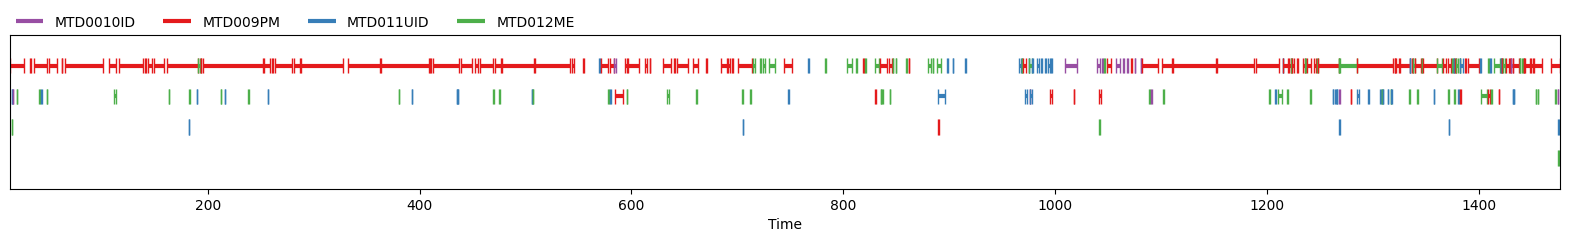

In [ ]:
file["annotation"]

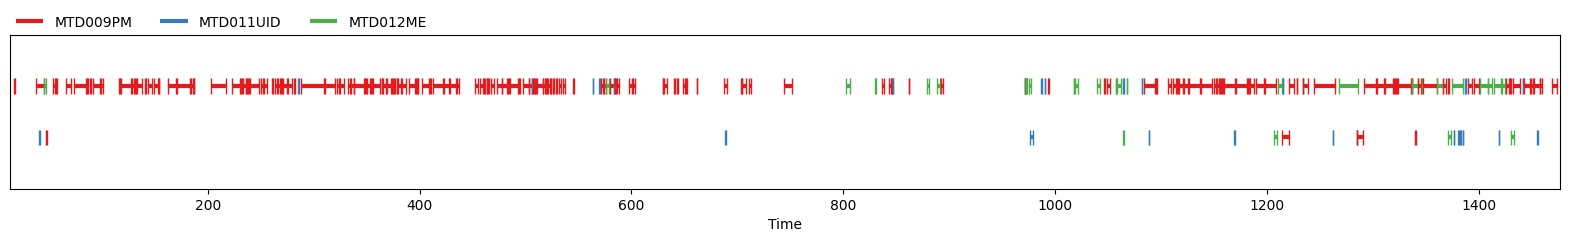

In [ ]:
file["pretrained pipeline"]

## Fine-tuning the segmentation model

When a sufficiently large training set of labeled conversations is available, fine-tuning the internal speaker segmentation model may lead to significant performance boost.

Starting from the pretrained model...

Let's pre trained it

In [ ]:
from pyannote.audio import Model
model = Model.from_pretrained("pyannote/segmentation", use_auth_token=True)

... we prepare it for fine-tuning on the training dataset:

In [ ]:
from pyannote.audio.tasks import Segmentation
task = Segmentation(
    dataset,
    duration=model.specifications.duration,
    max_num_speakers=len(model.specifications.classes),
    batch_size=32,
    num_workers=2,
    loss="bce",
    vad_loss="bce")
model.task = task
model.setup(stage="fit")

Protocol AMI-SDM.SpeakerDiarization.mini does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


The actual training is done with [`lightning`](https://github.com/Lightning-AI/lightning):

In [ ]:
# this takes approximately 15min to run on Google Colab GPU
from types import MethodType
from torch.optim import Adam
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)

# we use Adam optimizer with 1e-4 learning rate
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)

model.configure_optimizers = MethodType(configure_optimizers, model)

# we monitor diarization error rate on the validation set
# and use to keep the best checkpoint and stop early
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor=monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False,
)
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False,
)

callbacks = [RichProgressBar(), checkpoint, early_stopping]

# we train for at most 20 epochs (might be shorter in case of early stopping)
from pytorch_lightning import Trainer
trainer = Trainer(accelerator="gpu",
                  callbacks=callbacks,
                  max_epochs=5,
                  gradient_clip_val=0.5)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃       In sizes ┃                                  Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ [32, 1, 80000] │                              [32, 60, 293] │
│ 1 │ lstm              │ LSTM             │  1.4 M │  [32, 293, 60] │    [[32, 293, 256], [[8, 32, 128], [8, 32, │
│   │                   │                  │        │                │                                     128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │              ? │                                          ? │
│ 3 │ classifier        │ Linear           │    387 │ [32, 293, 128] │                               [32, 293, 3] │
│ 4 │ activation        │ Sigmoid          │      0 │   [32, 293, 3] │                               [32, 293, 3] │
│ 5 │ validation_metric │ MetricCollection │      0 │              ? │                                          ? │
└───┴───────────────────┴──────────────────┴────────┴────────────────┴────────────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5

Output()

In [ ]:
# save path to the best checkpoint for later use
finetuned_model = checkpoint.best_model_path

# uncomment to download the checkpoint
#from google.colab import files
#files.download(finetuned_model)

## Optimizing the pipeline hyper-parameters

The pretrained `pyannote/speaker-diarization` pipeline relies on its own set of hyper-parameters adapted to the internal `pyannote/segmentation` pretrained model:

In [ ]:
pretrained_hyperparameters = pretrained_pipeline.parameters(instantiated=True)
pretrained_hyperparameters

{'segmentation': {'min_duration_off': 0.5817029604921046,
  'threshold': 0.4442333667381752},
 'clustering': {'method': 'centroid',
  'min_cluster_size': 15,
  'threshold': 0.7153814381597874}}

There is no reason the above hyper-parameters are optimal for the newly finetuned speaker segmentation model. Let's optimize them:

* `segmentation.threshold` ($\theta$  in the [technical report](https://huggingface.co/pyannote/speaker-diarization/resolve/main/technical_report_2.1.pdf), between 0 and 1) controls the aggressiveness of speaker activity detection (i.e. a higher value will result in less detected speech);
* `clustering.threshold` ($\delta$  in the report, between 0 and 2) controls the number of speakers (i.e. a higher value will result in less speakers).
* `segmentation.min_duration_off` ($\Delta$ in the report, in seconds) controls whether intra-speaker pauses are filled. This usually depends on the downstream application so it is better to first force it to zero (i.e. never fill intra-speaker pauses) during optimization.
* `clustering.centroid` is the linkage used by the agglomerative clustering step. `centroid` has been found to be slightly better than `average`.
* `clustering.min_cluster_size` controls what to do with small speaker clusters. Clusters smaller than that are assigned to the most similar large cluster. `15` is a good default value.

We start by optimizing `segmentation.threshold` by assuming that the subsequent clustering step is perfect (cf. `OracleClustering`).

Here we are using our pre trained model to check the error rate

This will find the best segment

In [ ]:
# this takes approximately 5min to run on Google Colab GPU
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.pipeline import Optimizer

pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    clustering="OracleClustering",
)
# as reported in the technical report, min_duration_off can safely be set to 0.0
pipeline.freeze({"segmentation": {"min_duration_off": 0.0}})

optimizer = Optimizer(pipeline)
dev_set = list(dataset.development())

iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best segmentation threshold so far: {iteration['params']['segmentation']['threshold']}")
    if i > 20: break   # 50 iterations should give slightly better results

Best segmentation threshold so far: 0.6664448473161746
Best segmentation threshold so far: 0.2976220997528466
Best segmentation threshold so far: 0.2976220997528466
Best segmentation threshold so far: 0.2976220997528466
Best segmentation threshold so far: 0.2976220997528466
Best segmentation threshold so far: 0.2976220997528466
Best segmentation threshold so far: 0.2976220997528466
Best segmentation threshold so far: 0.2976220997528466
Best segmentation threshold so far: 0.2976220997528466
Best segmentation threshold so far: 0.2976220997528466
Best segmentation threshold so far: 0.2976220997528466
Best segmentation threshold so far: 0.3333374961414486
Best segmentation threshold so far: 0.35525487502617703
Best segmentation threshold so far: 0.35525487502617703
Best segmentation threshold so far: 0.35525487502617703
Best segmentation threshold so far: 0.35525487502617703
Best segmentation threshold so far: 0.35525487502617703
Best segmentation threshold so far: 0.35525487502617703
Best

Then, we use the optimized value of `segmentation.threshold` and optimize `clustering.threshold`.

In [ ]:
best_segmentation_threshold = optimizer.best_params["segmentation"]["threshold"]

This will find the best Clustering

In [ ]:
# this takes approximately 5min to run on Google Colab GPU
pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

pipeline.freeze({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
    },
})

optimizer = Optimizer(pipeline)
iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best clustering threshold so far: {iteration['params']['clustering']['threshold']}")
    if i > 20: break  # 50 iterations should give slightly better results

Best clustering threshold so far: 1.9453050552234887
Best clustering threshold so far: 1.9453050552234887
Best clustering threshold so far: 1.9453050552234887
Best clustering threshold so far: 1.9453050552234887
Best clustering threshold so far: 1.9453050552234887
Best clustering threshold so far: 1.9453050552234887
Best clustering threshold so far: 1.9453050552234887
Best clustering threshold so far: 1.9453050552234887
Best clustering threshold so far: 1.9453050552234887
Best clustering threshold so far: 0.6295098948242583
Best clustering threshold so far: 0.6295098948242583
Best clustering threshold so far: 0.6295098948242583
Best clustering threshold so far: 0.6295098948242583
Best clustering threshold so far: 0.6295098948242583
Best clustering threshold so far: 0.6295098948242583
Best clustering threshold so far: 0.6295098948242583
Best clustering threshold so far: 0.6295098948242583
Best clustering threshold so far: 0.6295098948242583
Best clustering threshold so far: 0.6295098948

Finally, we use the optimized values of `segmentation.threshold` and `clustering.threshold` to evaluate the performance of the finetuned pipeline:

In [ ]:
best_clustering_threshold = optimizer.best_params['clustering']['threshold']

In [ ]:
# this takes approximately 2min to run on Google Colab GPU
finetuned_pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

finetuned_pipeline.instantiate({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
        "threshold": best_clustering_threshold,
    },
})

metric = DiarizationErrorRate()

for file in dataset.test():
    # apply finetuned pipeline
    file["finetuned pipeline"] = finetuned_pipeline(file)

    # evaluate its performance
    metric(file["annotation"], file["finetuned pipeline"], uem=file["annotated"])

print(f"The finetuned pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

The finetuned pipeline reaches a Diarization Error Rate (DER) of 31.0% on AMI-SDM.SpeakerDiarization.mini test set.


Here you can see the error count is decrease, if we fine tunned it for more epoch then it should be way less

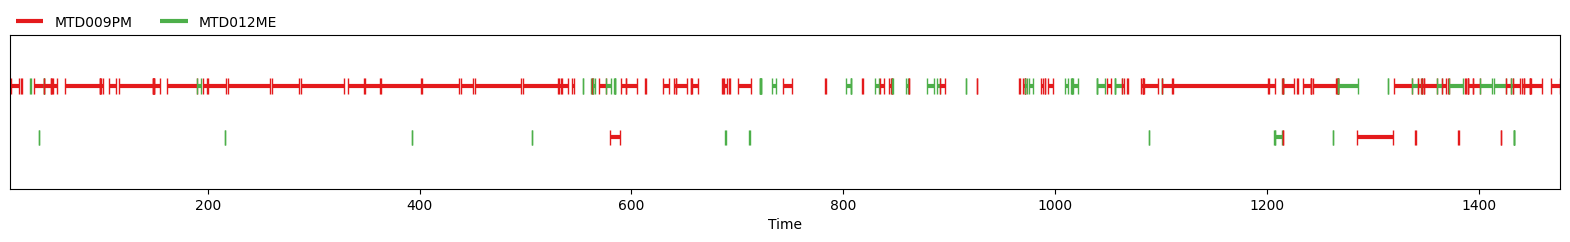

In [ ]:
file["finetuned pipeline"]

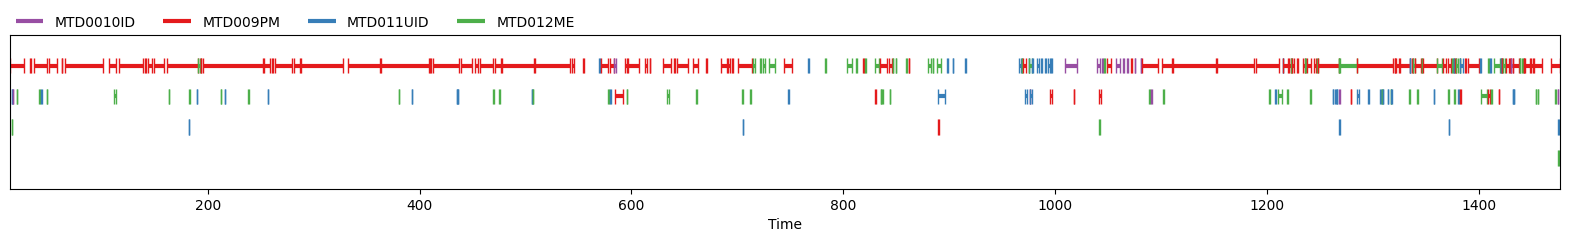

In [ ]:
file["annotation"]

## Conclusion

In just about half an hour (and 6 hours of training data), we managed to reduce the diarization error rate from 32.5% to 26.6%.

[Yours truly](https://herve.niderb.fr) used this very recipe for their submissions to several speaker diarization benchmarks organized in 2022. I reached:



Thankyou for watching, in th next video we will try to fine tuned this model on our own dataset